In [2]:
import pandas as pd
import requests

In [3]:
# After importing Pandas and requests, I go about acquiring politican info from OpenSecrets on my states represenatives.


url = "https://www.opensecrets.org/api/"
method1 = "getLegislators"
state_id1 = "FL"
apikey = "1e6b40d2ef1cd1955b8faf688cfc9f43"
payload1 = {
    "method": method1,
    "id": state_id1,
    "output": "json",
    "apikey": apikey
}

response1 = requests.get(url, params=payload1)
data1 = response1.json()

In [4]:
# print(data1)

# printing data1 fills our notebook with a great deal of text, but since it was neccesary for my process I left the code in place but used a # to keep it from running. 

In [5]:
# Since our data1 is rather messy, lets see if we can clean it up in a pandas dataframe. 

df1 = pd.DataFrame(data1["response"]["legislator"])
df1["cid"] = df1["@attributes"].apply(lambda x: x["cid"])
df1["firstlast"] = df1["@attributes"].apply(lambda x: x["firstlast"])
df1["party"] = df1["@attributes"].apply(lambda x: x["party"])
df1["first_elected"] = df1["@attributes"].apply(lambda x: x["first_elected"])
df1["exit_code"] = df1["@attributes"].apply(lambda x: x["exit_code"])
df1.drop(["@attributes"], axis=1, inplace=True)


In [6]:
display(df1)

,cid,firstlast,party,first_elected,exit_code
0,N00039503,Matt Gaetz,R,2016,0
1,N00037442,Neal Dunn,R,2016,0
2,N00045978,Kat Cammack,R,2020,0
3,N00051369,Aaron Bean,R,2022,0
4,N00039777,John Rutherford,R,2016,0
5,N00042403,Michael Waltz,R,2018,0
6,N00048179,Cory Mills,R,2022,0
7,N00029662,Bill Posey,R,2008,0
8,N00037422,Darren Soto,D,2016,0
9,N00049075,Maxwell Frost,D,2022,0


In [7]:
# Furthermore, lets make our cid into a list to use it for the next API, and lets keep it to candidates that we know for certain have full data. in our case that means only candidates elected in or before 2018.
cid_list = df1[df1["first_elected"].astype(int) <= 2018]["cid"].tolist()
print(cid_list)

['N00039503', 'N00037442', 'N00039777', 'N00042403', 'N00029662', 'N00037422', 'N00026335', 'N00027462', 'N00027514', 'N00027626', 'N00042808', 'N00037269', 'N00002893', 'N00030650', 'N00026106', 'N00025337', 'N00043290', 'N00030612']


In [8]:
# Excellent, we now have the cid, name and party alignment of every represenative from the state of Florida, lets now see about getting the sector totals for these politicians.

method2 = "candSector"
data_list = []
for cid in cid_list:
    payload2 = {
        "method": method2,
        "cid": cid,
        "output": "json",
        "apikey": apikey
    }
    response2 = requests.get(url, params=payload2)    
    data2 = response2.json()
    data_list.append(data2)

In [9]:
# Much like data1, data_list is rather messy but running a print command of it once was neccesary to fixing up the information. However it also presents us a much larger wall of text that isn't neccesary to view.
# print(data_list) 

In [10]:
df2 = pd.DataFrame(columns=['cid', 'sector_name', 'sectorid', 'indivs', 'pacs', 'total'])

for data in data_list:
    cid = data['response']['sectors']['@attributes']['cid']
    sectors = data['response']['sectors']['sector']
    for sector in sectors:
        sector_name = sector['@attributes']['sector_name']
        sectorid = sector['@attributes']['sectorid']
        indivs = sector['@attributes']['indivs']
        pacs = sector['@attributes']['pacs']
        total = sector['@attributes']['total']
        df2 = pd.concat([df2, pd.DataFrame({'cid': cid, 'sector_name': sector_name, 'sectorid': sectorid, 'indivs': indivs, 'pacs': pacs, 'total': total}, index=[0])], ignore_index=True)

In [11]:
display(df2)

,cid,sector_name,sectorid,indivs,pacs,total
0,N00039503,Agribusiness,A,14666,24000,38666
1,N00039503,Communic/Electronics,B,24150,43500,67650
2,N00039503,Construction,C,8900,6500,15400
3,N00039503,Defense,D,3200,70000,73200
4,N00039503,Energy/Nat Resource,E,11350,19000,30350
...,...,...,...,...,...,...
223,N00030612,Transportation,M,465801,264828,730629
224,N00030612,Misc Business,N,2083567,409800,2493367
225,N00030612,Labor,P,465,25500,25965
226,N00030612,Ideology/Single-Issue,Q,1740159,600704,2340863


In [12]:
# We now have two dataframs regarding various personal information on our politicans and the donations to them. From here I will merge the two datasets and see if there are relationships between our state politicans and the sectors of the economy that donates to them.
merged_df = pd.merge(df1, df2, on='cid')
display(merged_df)
print(merged_df.dtypes)

,cid,firstlast,party,first_elected,exit_code,sector_name,sectorid,indivs,pacs,total
0,N00039503,Matt Gaetz,R,2016,0,Agribusiness,A,14666,24000,38666
1,N00039503,Matt Gaetz,R,2016,0,Communic/Electronics,B,24150,43500,67650
2,N00039503,Matt Gaetz,R,2016,0,Construction,C,8900,6500,15400
3,N00039503,Matt Gaetz,R,2016,0,Defense,D,3200,70000,73200
4,N00039503,Matt Gaetz,R,2016,0,Energy/Nat Resource,E,11350,19000,30350
...,...,...,...,...,...,...,...,...,...,...
223,N00030612,Marco Rubio,R,2010,0,Transportation,M,465801,264828,730629
224,N00030612,Marco Rubio,R,2010,0,Misc Business,N,2083567,409800,2493367
225,N00030612,Marco Rubio,R,2010,0,Labor,P,465,25500,25965
226,N00030612,Marco Rubio,R,2010,0,Ideology/Single-Issue,Q,1740159,600704,2340863


cid              object
firstlast        object
party            object
first_elected    object
exit_code        object
sector_name      object
sectorid         object
indivs           object
pacs             object
total            object
dtype: object


In [13]:
# Some of our columns are objects which would make later analysis difficult, lets change them into integers
merged_df['firstlast'] = merged_df['firstlast'].astype(str) 
merged_df['party'] = merged_df['party'].astype(str) 
merged_df['first_elected'] = merged_df['first_elected'].astype(float) 
merged_df['sector_name'] = merged_df['sector_name'].astype(str)
merged_df['indivs'] = merged_df['indivs'].astype(float)
merged_df['pacs'] = merged_df['pacs'].astype(float)
merged_df['total'] = merged_df['total'].astype(float)




In [14]:
# Now that we  have our data in a usable format, lets get into the analysis
merged_df.nlargest(3, 'total')
# Our 3 largest donations were as follows, and all 3 go to our Florida's Senators. 

,cid,firstlast,party,first_elected,exit_code,sector_name,sectorid,indivs,pacs,total
220,N00030612,Marco Rubio,R,2010.0,0,Finance/Insur/RealEst,F,4544379.0,487280.0,5031659.0
227,N00030612,Marco Rubio,R,2010.0,0,Other,W,4203948.0,8000.0,4211948.0
214,N00043290,Rick Scott,R,2018.0,0,Other,W,3355122.0,0.0,3355122.0


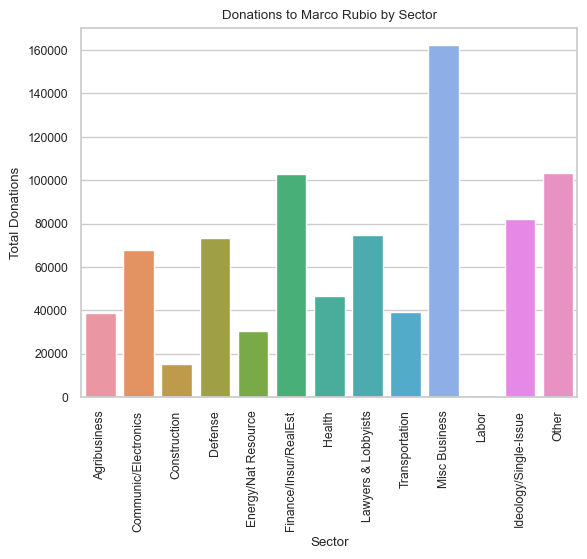

In [38]:
#Lets look more into this Rubio character, where is he getting his financing from?
rubio_cid = 'N00039503'
cid_df = merged_df[merged_df['cid'] == rubio_cid]


# Lets start by adding in some graphing tools
import matplotlib.pyplot as plt
import seaborn as sns
# plot the data using seaborn
sns.barplot(x='sector_name', y='total', data=cid_df)
plt.title('Donations to Marco Rubio by Sector')
plt.xlabel('Sector')
plt.ylabel('Total Donations')
plt.xticks(rotation=90)
plt.show()

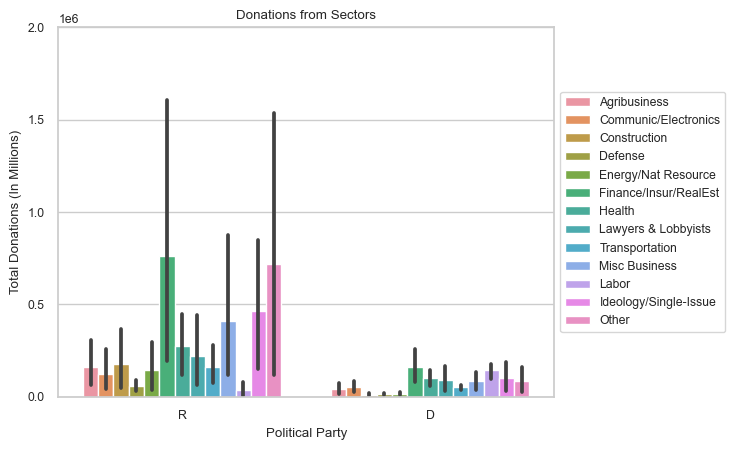

In [39]:
sns.set(font_scale=0.8) 
sns.set_style("whitegrid") 
sns.barplot(x="party", y='total', hue="sector_name", data=merged_df)
plt.title('Donations from Sectors')
plt.xlabel('Political Party')
plt.ylabel('Total Donations (In Millions)')
plt.yticks(range(0, 2000001, 500000))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [17]:
# As we can see here, the data indicates that based off party lines, republicans are largely the ones getting the most donations in just about every section, with some small exceptions. 